In [1]:
import kagglehub

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import shuffle

d:\anaconda3\envs\python_3_12_9\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#https://www.kaggle.com/datasets/whenamancodes/fraud-detection
path = kagglehub.dataset_download("whenamancodes/fraud-detection")
print("Path to dataset files:", path)
df = pd.read_csv(path + "\\creditcard.csv")
display(df.head())
print(df.shape)

Path to dataset files: C:\Users\miaje\.cache\kagglehub\datasets\whenamancodes\fraud-detection\versions\1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)


##### About this dataset

* Contains transactions made by credit cards in September 2013 by European cardholders.
* Presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 
* Highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.
* Contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Due to confidentiality issues, the original features and more background information about the data cannot be provided. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
df_fraud = df[df.Class == 1]
df_legit = df[df.Class == 0]
print(f"{round((df_fraud.shape[0] / df.shape[0])*100, 2)}% fraudulent")

0.17% fraudulent


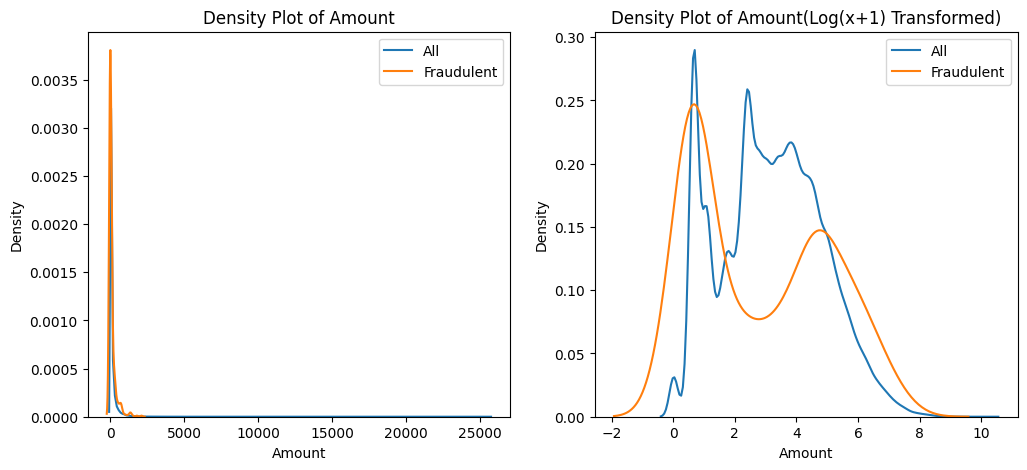

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df.Amount, label="All", ax=ax[0])
sns.kdeplot(df_fraud.Amount, label="Fraudulent", ax=ax[0])
ax[0].set_title("Density Plot of Amount")
ax[0].legend()

sns.kdeplot(np.log1p(df.Amount), label="All", ax=ax[1])
sns.kdeplot(np.log1p(df_fraud.Amount), label="Fraudulent", ax=ax[1])
ax[1].set_title("Density Plot of Amount(Log(x+1) Transformed)")
ax[1].legend()

plt.show()

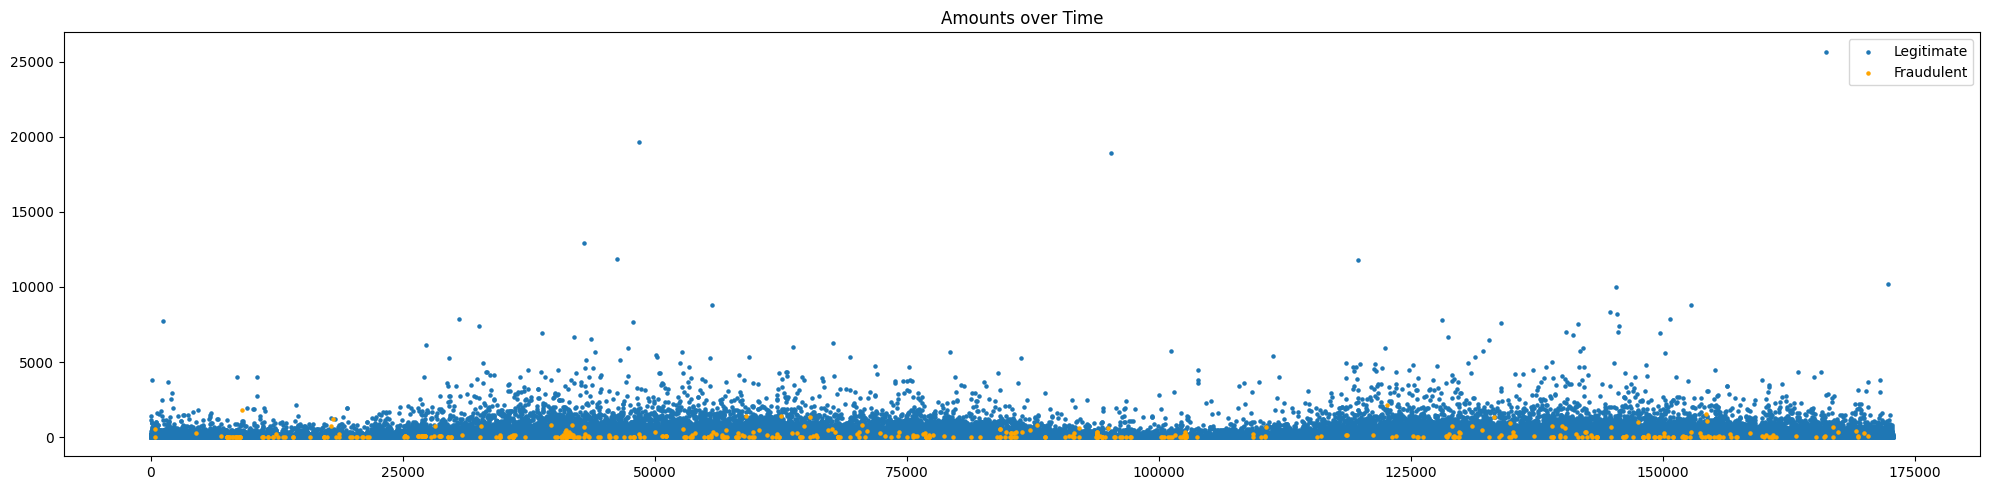

In [5]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.scatter(df_legit.Time, df_legit.Amount, s=5, label="Legitimate")
plt.scatter(df_fraud.Time, df_fraud.Amount, s=5, c="orange", label="Fraudulent")
plt.title("Amounts over Time")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def plot_prfs_vs_threshold(y_true, probs, thresholds=None, title=None):
    """
    Plots Precision, Recall, and F1 vs. probability threshold,
    using sklearn.metrics.precision_recall_fscore_support at each threshold.
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    prec, rec, f1 = [], [], []
    for t in thresholds:
        y_pred = (probs >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        prec.append(p); rec.append(r); f1.append(f)

    plt.figure()
    plt.plot(thresholds, prec, label="Precision")
    plt.plot(thresholds, rec, label="Recall")
    plt.plot(thresholds, f1, label="F1")
    plt.xlabel("Probability threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid(True, linewidth=0.3, alpha=0.5)
    plt.show()


def plot_prfs_bars(y_true, probs, threshold, title=None):
    """
    Bar chart of Precision, Recall, and F1 at a specific threshold,
    computed with precision_recall_fscore_support.
    """
    y_pred = (probs >= threshold).astype(int)
    p, r, f, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    plt.figure()
    plt.bar(["Precision", "Recall", "F1"], [p, r, f])
    plt.ylim(0, 1)
    if title:
        plt.title(title)
    plt.grid(axis="y", linewidth=0.3, alpha=0.5)
    plt.show()

In [9]:
# train and fit and isolation forest model on unlabelled data
def fit_isolation_forest(X, random_state=0):
    iso = IsolationForest(
        n_estimators=400,
        max_samples='auto',
        contamination='auto',  #threshold to be set once SME labels have been collected
        bootstrap=False,
        n_jobs=-1,
        random_state=random_state
    )
    iso.fit(X)
    anom_score = -iso.decision_function(X)
    return iso, pd.Series(anom_score, index=X.index, name="if_score")

# collect a sample of data for SMEs to review
# should include: top N high scores, plus some diverse/uncertain mid-score samples
def propose_for_review(scores: pd.Series, top_n=200, mid_quantile_range=(0.70, 0.90), mid_sample=200, random_state=0):
    rng = np.random.default_rng(random_state)
    # top N scores
    top_idx = scores.sort_values(ascending=False).head(top_n).index
    # mid scores
    q_low, q_high = scores.quantile([mid_quantile_range[0], mid_quantile_range[1]])
    mid_pool = scores[(scores >= q_low) & (scores <= q_high)]
    mid_n = min(mid_sample, len(mid_pool))
    mid_idx = rng.choice(mid_pool.index, size=mid_n, replace=False) if mid_n > 0 else []
    # combine all samples
    proposed = pd.Index(top_idx).append(pd.Index(mid_idx)).unique()
    return proposed

# after collecting actual labels from SMEs, create new dataset with "label" column
def build_labeled_dataset(X_all: pd.DataFrame, if_scores: pd.Series, sme_labels: pd.DataFrame):
    labeled_idx = X_all.index.intersection(sme_labels["expense_id"])
    y = sme_labels.set_index("expense_id").loc[labeled_idx, "label"].astype(int)
    X_lab = X_all.loc[labeled_idx].copy()
    X_lab = X_lab.assign(if_score=if_scores.loc[labeled_idx].values)  # add IF score as a feature
    return X_lab, y


# train and fit a new isolation forest model on labelled data
def train_supervised_with_calibration(X_lab: pd.DataFrame, y: pd.Series, base_model=None, method="isotonic", random_state=0):
    if base_model is None:
        # robust baseline
        # handles non-linearities
        # set class_weight for imbalance
        base_model = RandomForestClassifier(n_estimators=400, max_depth=None, class_weight="balanced", n_jobs=-1, random_state=random_state)
    # keep a holdout for evaluation and thresholding
    X_tr, X_val, y_tr, y_val = train_test_split(X_lab, y, test_size=0.25, stratify=y, random_state=random_state)
    cal = CalibratedClassifierCV(base_model, method=method, cv=5)
    cal.fit(X_tr, y_tr)
    # evaluate
    val_probs = cal.predict_proba(X_val)[:, 1]
    ap = average_precision_score(y_val, val_probs)
    print(f"Validation Average Precision (PR AUC): {ap:.3f}")
    return cal, (X_val, y_val)

# select a decision rule (threshold):
# (a) business-cost oriented (maximize F_beta)
def choose_threshold_for_fbeta(y_true, probs, beta=2.0):
    precision, recall, thresh = precision_recall_curve(y_true, probs)
    # avoid div-by-zero
    fbeta = (1 + beta**2) * (precision * recall) / np.clip(beta**2 * precision + recall, 1e-12, None)
    best_i = np.nanargmax(fbeta)
    # precision_recall_curve returns len(thresh) = len(precision)-1
    # map index accordingly
    if best_i == len(thresh): best_i -= 1
    return float(thresh[best_i])

# (b) workload oriented (top-K per batch/day)
def choose_threshold_for_topk(probs, k):
    if k <= 0 or k > len(probs):
        raise ValueError("k must be in (0, len(probs)].")
    kth = np.sort(probs)[-k]  # value at rank k
    return float(kth)

# score and queue all samples for SME review
def score_and_queue(X_all: pd.DataFrame, if_scores: pd.Series, cal_model, threshold=None, daily_quota=None):
    X_aug = X_all.assign(if_score=if_scores.values)
    probs = pd.Series(cal_model.predict_proba(X_aug)[:, 1], index=X_all.index, name="anomaly_prob")
    if daily_quota is not None and threshold is None:
        # Workload-based: take top-N each day
        queue_idx = probs.sort_values(ascending=False).head(daily_quota).index
        chosen_threshold = float(probs.loc[queue_idx].min())
    else:
        if threshold is None:
            # Fallback: default to top 1% if nothing else is provided
            threshold = np.quantile(probs, 0.99)
        queue_idx = probs[probs >= threshold].index
        chosen_threshold = float(threshold)
    queue = pd.DataFrame({
        "anomaly_prob": probs.loc[queue_idx],
        "if_score": if_scores.loc[queue_idx]
    }).sort_values("anomaly_prob", ascending=False)
    return queue, probs, chosen_threshold


# assemble the pipeline
def full_cycle(X_all, sme_labels_batch=None, daily_quota=200, beta=None, random_state=0):
    """
    One training/scoring cycle.
    - Fit isolation forest (IF)
    - If provided labels exist, train supervised + calibrate and set threshold.
    - Produce a queue for next SME review batch.
    """
    iso, if_scores = fit_isolation_forest(X_all, random_state=random_state)

    if sme_labels_batch is None or len(sme_labels_batch) == 0:
        # Cold start: just send a smart batch for review
        proposed = propose_for_review(if_scores, top_n=200, mid_sample=200, random_state=random_state)
        initial_queue = (
            pd.DataFrame({"if_score": if_scores.loc[proposed]})
            .assign(priority_rank=lambda df: df["if_score"].rank(ascending=False, method="first"))
            .sort_values("priority_rank")
        )
        print("Cold-start review batch prepared (no labels yet).")
        return {"iso_model": iso, "if_scores": if_scores, "review_queue": initial_queue}

    # Build labeled dataset
    X_lab, y = build_labeled_dataset(X_all, if_scores, sme_labels_batch)
    display(X_lab)
    # Shuffle to reduce any ordering bias
    X_lab, y = shuffle(X_lab, y, random_state=random_state)

    cal_model, (X_val, y_val) = train_supervised_with_calibration(X_lab, y, method="isotonic", random_state=random_state)
    val_probs = cal_model.predict_proba(X_val)[:, 1]

    if beta is not None:
        thr = choose_threshold_for_fbeta(y_val, val_probs, beta=beta)
        queue, probs, chosen_threshold = score_and_queue(X_all, if_scores, cal_model, threshold=thr)
    else:
        # Workload-based default
        queue, probs, chosen_threshold = score_and_queue(X_all, if_scores, cal_model, daily_quota=daily_quota)

    print(f"Chosen threshold: {chosen_threshold:.4f}")

    # Plots using precision_recall_fscore_support
    # On the validation set across thresholds:
    plot_prfs_vs_threshold(
        y_true=y_val.values,
        probs=val_probs,
        title="Validation Precision/Recall/F1 vs Threshold"
    )
    # At the chosen operational threshold (still on validation set):
    plot_prfs_bars(
        y_true=y_val.values,
        probs=val_probs,
        threshold=chosen_threshold,
        title=f"Validation metrics @ threshold={chosen_threshold:.3f}"
    )

    return {
        "iso_model": iso,
        "if_scores": if_scores,
        "calibrated_model": cal_model,
        "chosen_threshold": chosen_threshold,
        "review_queue": queue
    }

Cold-start review batch prepared (no labels yet).


,if_score,priority_rank
274771,0.268831,1.0
173353,0.247708,2.0
151296,0.246237,3.0
58465,0.244590,4.0
220090,0.239858,5.0


,expense_id,label
0,274771,0
1,173353,0
2,151296,0
3,58465,0
4,220090,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,if_score
731,550.0,-1.203351,1.774641,0.299300,-0.418265,0.484617,0.071523,0.046899,-1.492543,0.308865,0.271295,-1.532808,-0.702163,-0.258116,-0.485220,1.057280,0.787660,-0.357701,0.382133,0.350550,0.035568,1.100059,-1.561118,0.054078,-1.119103,0.145057,0.182843,0.528716,0.218048,2.67,-0.076067
1384,1074.0,-2.445204,-0.505494,0.164511,-0.449658,0.460784,-0.509035,-0.490478,1.060597,-0.385591,-1.053488,-0.553817,0.207330,-0.933946,0.969621,-0.758698,0.863809,-0.533855,0.559857,0.502850,0.171937,0.060361,-0.802101,-0.299229,-0.831608,-0.055518,0.315454,-0.467257,-0.167591,1.00,-0.085606
1632,1264.0,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,3.702177,-1.843056,2.427123,-1.652836,3.635042,4.087802,-1.654892,-0.888406,0.752276,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43,0.214275
2095,1614.0,-2.962376,2.607363,-0.067883,-0.889316,-1.360313,-0.983393,-0.534070,1.473261,0.478763,0.706617,0.721613,1.005330,-0.837317,0.779043,-0.961018,0.400195,0.030062,-0.045642,-0.202505,0.420581,-0.185342,-0.455737,0.160595,0.506340,0.078372,0.299425,0.544370,0.349456,1.00,-0.069467
3619,3094.0,-0.302521,0.447474,-0.495757,-3.214799,2.705041,2.762440,0.593847,0.556451,0.697720,-1.090181,-0.111088,0.062652,-0.238457,0.215738,1.069356,-0.255231,-1.072085,0.485110,0.271315,0.156089,0.007343,0.250886,-0.331600,1.009952,0.233730,-0.824471,0.241305,-0.020359,1.00,-0.071358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283399,171565.0,2.190208,-1.963704,0.459281,-1.294053,-2.247734,0.556156,-2.374559,0.308539,0.200355,1.308331,-1.747234,-0.697872,0.284969,-1.491509,-0.841293,-0.327028,0.579036,0.517388,-0.117367,-0.414138,-0.027399,0.653444,0.253390,0.671646,-0.404998,-0.053334,0.096183,-0.020795,18.17,-0.080824
283492,171635.0,-0.501657,0.813920,-0.668644,-1.025468,1.649166,1.688387,0.277851,0.920540,-0.313646,-0.859430,-0.664322,0.827168,0.980358,0.331360,0.660601,-1.028067,0.621156,-2.468926,-1.354056,-0.130041,-0.130454,-0.223878,0.204565,-1.302547,-0.630721,0.277561,0.191599,0.006267,11.99,-0.076263
283658,171768.0,-2.467223,2.253708,0.281877,4.260362,-0.553394,1.299202,-0.592281,1.061158,-0.725846,2.750826,-1.618971,-0.093822,1.292422,-0.238490,0.701280,0.289972,0.107926,0.595924,0.956358,0.515915,0.130433,1.004529,-0.085599,0.517418,-0.373533,0.427202,0.000554,-0.090862,40.04,-0.059351
284249,172273.0,-9.030538,-11.112584,-16.233798,3.592021,-40.427726,23.917837,44.054461,-7.277778,-4.210637,-7.776435,0.214173,-4.499851,0.241005,0.537895,2.901938,2.326099,-0.402142,1.257379,2.008145,2.454553,-0.269048,0.988144,7.040028,0.347693,2.520869,2.342495,3.478175,-2.713136,10199.44,0.205153


Validation Average Precision (PR AUC): 0.055
Chosen threshold: 0.0925


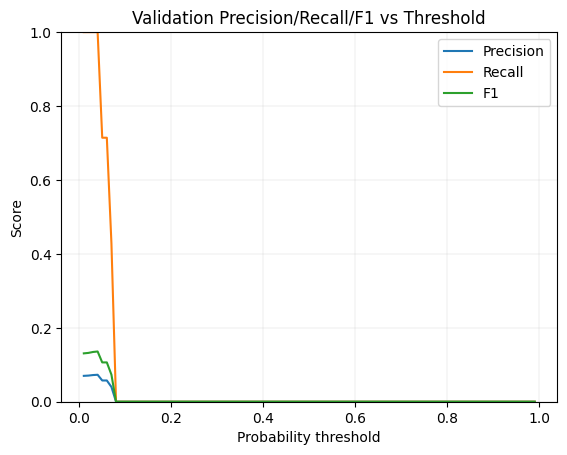

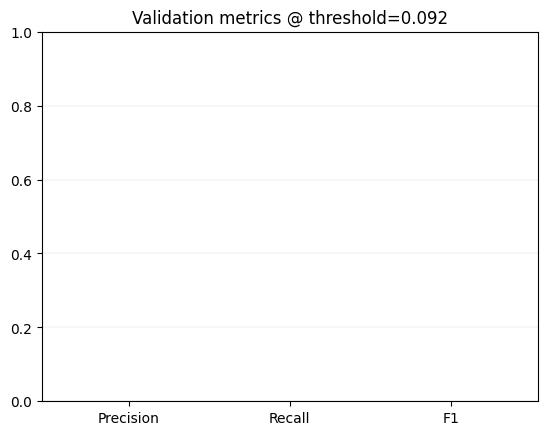

In [11]:
response = "Class"
X_all = df.drop(columns=[response])
# y = df[response]

# cold start to get SMEs labeling:
cycle0 = full_cycle(X_all)
len_cycle = len(cycle0["review_queue"])
display(cycle0["review_queue"].head())

# SMEs review those expense_ids and return a DataFrame
import random
random.seed(30)
sme_labels_batch = pd.DataFrame({
    "expense_id": cycle0["review_queue"].index,
    "label": random.choices([0, 1], weights=[0.9, 0.1], k=len_cycle)  # 1 = anomalous, 0 = legitimate
})
display(sme_labels_batch.head())

# train with feedback and produce next queue
cycle1 = full_cycle(X_all, sme_labels_batch=sme_labels_batch, daily_quota=200, random_state=0)

# on subsequent days/weeks, append new labels and re-run full_cycle with the growing label set.